# 1) Importing Libraries

In [719]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import xgboost as xgb
import category_encoders as ce
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder, LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, make_scorer
from sklearn.model_selection import train_test_split, cross_val_score

# 2) Loading Data

In [720]:
data = pd.read_csv("E:/Python Project(VS Code)/Web Scraping House Prices in Egypt/units_details.csv")
data.head()

,name,latitude,longitude,area(Sq. M.),bedrooms,bathrooms,region,locality,unit_type,price(EGP)
0,"3-bedroom chalet, fully finished with air cond...",31.177560,27.618041,170,3.0,2.0,Matruh,North Coast,Chalet,10000000
1,Villa Ready To Move with Luxury Life Style in ...,30.076691,30.876760,320,5.0,5.0,Giza,Sheikh Zayed,Villa,17000000
2,High End Life Style in a completed villa at Go...,30.000023,31.034284,225,4.0,4.0,Giza,6th of October,Villa,15500000
3,Luxury Villa in Alma Compound Sheikh Zayed,30.026118,31.009526,320,4.0,5.0,Giza,Sheikh Zayed,Villa,17000000
4,studio for sale in privado 63m lake view old c...,30.096464,31.667057,63,0.0,1.0,Cairo,Madinaty,Apartment,3282000


# 3) Data Preprocessing

In [721]:
# Check for missing values in the dataset
data.isnull().sum()

name             0
latitude         0
longitude        0
area(Sq. M.)     0
bedrooms        71
bathrooms       71
region           0
locality         0
unit_type        0
price(EGP)       0
dtype: int64

In [722]:
# Drop rows with missing values (inplace=True modifies the original)
data.dropna(inplace=True)
data.isnull().sum()

name            0
latitude        0
longitude       0
area(Sq. M.)    0
bedrooms        0
bathrooms       0
region          0
locality        0
unit_type       0
price(EGP)      0
dtype: int64

In [723]:
# Convert bathroom and bedroom columns to integers (they are floats)
data["bathrooms"] = data["bathrooms"].astype(int)
data["bedrooms"] = data["bedrooms"].astype(int)

# 4) Feature Engineering

In [724]:
df = pd.DataFrame(data)

In [725]:
# New Feature 1: Ratio of bedrooms to bathrooms
df["room_bath_ratio"] = df["bedrooms"] / (df["bathrooms"] + 1e-3)  # add small value to avoid division by 0

In [726]:
# New Feature 2: Price per square meter
df["price_per_sqm"] = df["price(EGP)"] / df["area(Sq. M.)"]

In [727]:
# One-hot encode categorical variables: region, unit_type, locality
df = df.merge(pd.get_dummies(df["region"], drop_first=True, prefix="region"), left_index=True, right_index=True)
df = df.merge(pd.get_dummies(df["unit_type"], drop_first=True, prefix="unit_type"), left_index=True, right_index=True)
df = df.merge(pd.get_dummies(df["locality"], drop_first=True, prefix="locality"), left_index=True, right_index=True)

In [728]:
# Drop original categorical columns (since we encoded them)
df.drop(['name', 'region', 'unit_type', 'locality'], axis=1, inplace=True)

# 5) Data Visualization

#### Visualizing Price Distribtion

C:\Users\aelsh\AppData\Local\Temp\ipykernel_2216\2600361920.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data["price(EGP)"])   # shows how prices are spread


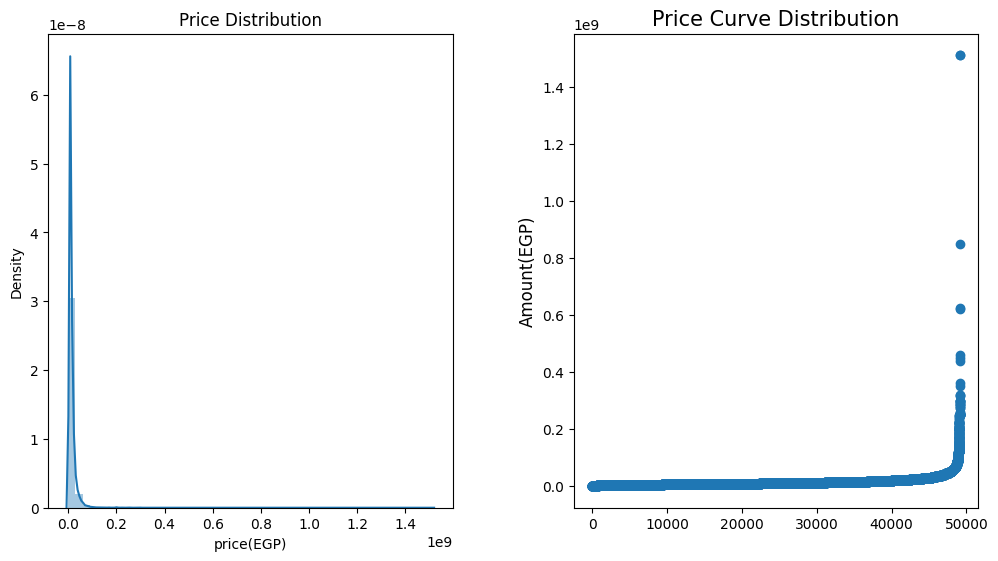

In [729]:
plt.figure(figsize=(12, 6))

# Histogram (distribution of prices)
plt.subplot(121)
plt.title("Price Distribution")
sns.distplot(data["price(EGP)"])   # shows how prices are spread

# Price curve distribution (sorted scatter plot)
plt.subplot(122)
g1 = plt.scatter(range(data.shape[0]), np.sort(data["price(EGP)"].values))
g1  = plt.title("Price Curve Distribution", fontsize = 15)
g1 = plt.ylabel("Amount(EGP)", fontsize=12)

plt.subplots_adjust(wspace = 0.3, hspace = 0.5, top = 0.9)
plt.show()

#### Bathrooms Analysis

Freuency bathroom description:
bathrooms
2     17748
3     15841
4      6588
1      4892
5      2465
6       830
7       329
0       170
8       135
11       55
10       33
9        19
Name: count, dtype: int64


C:\Users\aelsh\AppData\Local\Temp\ipykernel_2216\3905098529.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(),rotation=90)
C:\Users\aelsh\AppData\Local\Temp\ipykernel_2216\3905098529.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(ax2.get_xticklabels(),rotation=90)
C:\Users\aelsh\AppData\Local\Temp\ipykernel_2216\3905098529.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax0.set_xticklabels(ax0.get_xticklabels(),rotation=90)


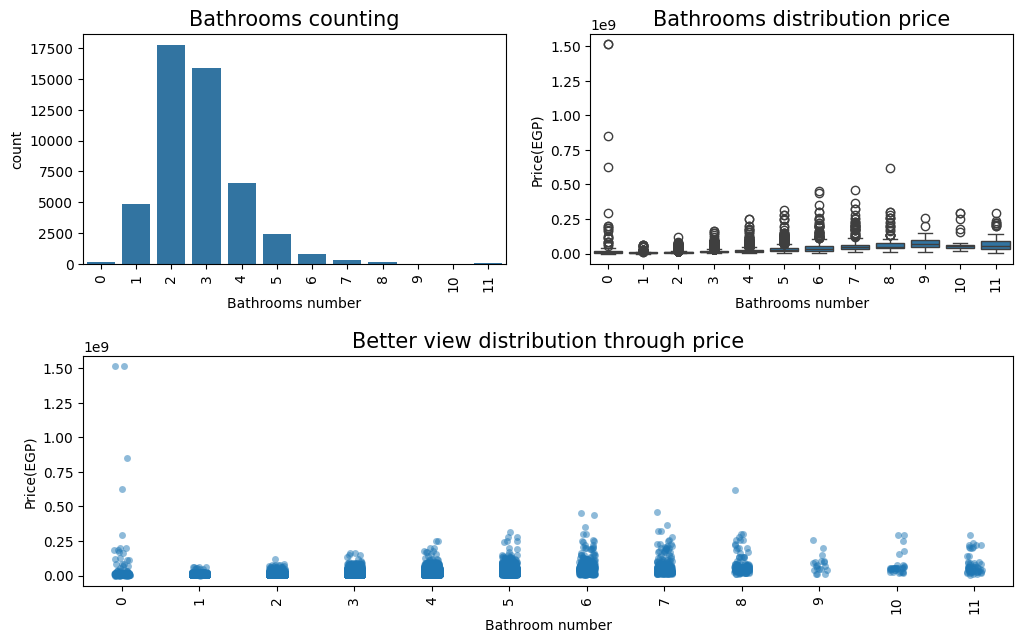

In [732]:
print("Freuency bathroom description:")
print(data["bathrooms"].value_counts())   # show how many listings per bathroom count

plt.figure(figsize = (12,8))
plt.subplots_adjust(hspace = 0.4, top = 0.8)

# Plot 1: Count how many properties have each bathroom number
ax1 = plt.subplot(221)
ax1 = sns.countplot(x="bathrooms", data=data, ax=ax1)
ax1.set_xticklabels(ax1.get_xticklabels(),rotation=90)
ax1.set_title("Bathrooms counting", fontsize=15)
ax1.set_xlabel("Bathrooms number")
ax1.set_ylabel("count")

# Plot 2: Boxplot of prices grouped by bathroom count
ax2 = plt.subplot(222)
ax2 = sns.boxplot(x="bathrooms", y='price(EGP)', data=data, ax=ax2)
ax2.set_xticklabels(ax2.get_xticklabels(),rotation=90)
ax2.set_title("Bathrooms distribution price", fontsize=15)
ax2.set_xlabel("Bathrooms number")
ax2.set_ylabel("Price(EGP)")

# Plot 3: Stripplot (scatter + jitter) for better price distribution view
ax0 = plt.subplot(212)
ax0 = sns.stripplot(x="bathrooms", y="price(EGP)", data=data,
                    alpha=0.5, jitter=True)
ax0.set_title("Better view distribution through price", fontsize=15)
ax0.set_xlabel("Bathroom number")
ax0.set_ylabel("Price(EGP)")
ax0.set_xticklabels(ax0.get_xticklabels(),rotation=90)

plt.show()

# 6) Train/Test Split

In [733]:
X = df.drop(columns=["price(EGP)"])  # Features (independent variables)
y = np.log1p(df["price(EGP)"])       # Target (log of price for normalization)

In [734]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# 7) XGBoost Model

In [735]:
# Define model
xgb_model = xgb.XGBRegressor(
    n_estimators=500,     # number of trees
    learning_rate=0.05,   # step size shrinkage
    max_depth=6,          # depth of each tree
    subsample=0.8,        # use 80% of data per tree
    colsample_bytree=0.8, # use 80% of features per tree
    random_state=42,
    objective='reg:squarederror' # regression task
)

In [736]:
# Fit the model
xgb_model.fit(X_train, y_train)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [737]:
# Predictions
y_pred = xgb_model.predict(X_test)

In [738]:
# Evaluation
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

In [739]:
print("MSE:", mse)
print("RMSE:", rmse)
print("R²:", r2)

MSE: 0.005227231518361291
RMSE: 0.07229959556153334
R²: 0.9904312732346592


# 8) Testing xgb_model

In [746]:
# Pick 10 random samples from test set
sample_idx = np.random.choice(X_test.index, size=10, replace=False)
X_sample = X_test.loc[sample_idx]
y_true_sample = y_test.loc[sample_idx]

# Predict on these samples
y_pred_sample = xgb_model.predict(X_sample)

# Convert back from log scale (because you used log1p on price)
y_true_original = np.expm1(y_true_sample)  
y_pred_original = np.expm1(y_pred_sample)

# Create comparison DataFrame
comparison_df = pd.DataFrame({
    "Actual Price (EGP)": y_true_original.round(0),
    "Predicted Price (EGP)": y_pred_original.round(0)
}, index=sample_idx)

print(comparison_df)

       Actual Price (EGP)  Predicted Price (EGP)
26076          11000000.0             10859325.0
45246          42000000.0             40994864.0
20268           8000000.0              7922924.0
27907           3400000.0              3363779.0
47351          45000000.0             46170956.0
49172          29000000.0             28705296.0
5163           17000000.0             17276404.0
38281           3600000.0              3586856.0
30866           5000000.0              5019052.0
46399          14800000.0             14596913.0
